In [8]:
import jax.numpy as jnp
from timing import poly_gen_D, timing_van_jax
from out_loop import objective_func
from out_loop import objective_func_no_err

dummy_cov = jnp.load("dummy_cov.npz")
dummy_chi2res = jnp.load("dummy_chi2res.npz")
dummy_pcoeffs = jnp.load("dummy_pceoffs.npz")
jnp.shape(dummy_chi2res)
# coeff = dict(zip((range(jnp.size(dummy_pcoeffs))), (dummy_pcoeffs[k] for k in dummy_pcoeffs)))
# cov = dict(zip((range(jnp.size(dummy_cov_arr))), (dummy_cov_arr[k] for k in dummy_cov_arr)))
coeff = dict(dummy_pcoeffs)
cov = dict(dummy_cov)

In [9]:
p = jnp.array([2, 3])

poly = timing_van_jax([p], 3)[0]

coeff_list = list(coeff.values())
jnp.matmul(coeff_list[1], poly.T)
coeff_list[1]

#Setting target to be something completely random, we expect the objective function to be extremely high
target_d = range(40)
targ_sig = jnp.ones(40)

print("We expect this to be high ", objective_func(p, target_d, targ_sig, list(coeff.values()), list(cov.values())))

#Setting target to be exactly what it would be with p = 2, 3, we expect the objective function to be arbitrarily low
target_d = jnp.matmul(jnp.array(list(coeff.values())), poly.T)
print("We expect this to be low ", objective_func(p, target_d, targ_sig, list(coeff.values()), list(cov.values())))

jnp.size(jnp.array(list(coeff.values())), axis=0)

We expect this to be high  3608.5068
We expect this to be low  4.3565507e-13


40

In [15]:
#Testing dummy_data

import scipy.optimize as opt
import jax.random as random
from jax import jacfwd, jacrev

#json file in the format binid keyed to array of [target value, value error]
import json
with open('target_data.json', 'r') as f:
    target_data = json.loads(f.read())
target_values = {k: target_data[k][0] for k in target_data}
target_error = {k: target_data[k][1] for k in target_data}

#initial guess in apprentices is kinda a mess, it has an array of possible xs from a scaler mess I don't understand
#that is processed from some input files; it starts with the value in scaler with the smallest objective.
#An easier option that could be implemented here is to use the MC run with min objective from the original h5 file 

p_guess = jnp.array([1.7,-1.1])
args = (list(target_values.values()), list(target_error.values()), list(coeff.values()))
p_opt = opt.minimize(objective_func_no_err, p_guess, args = args, method='Nelder-Mead')
print(p_opt)

p_guess = jnp.array([1.7,-1.1])
args = (list(target_values.values()), list(target_error.values()), list(coeff.values()), list(cov.values()))
p_opt = opt.minimize(objective_func, p_guess, args = args, method='Nelder-Mead')
print(p_opt)


 final_simplex: (array([[ 1.48637124, -0.9912348 ],
       [ 1.48637131, -0.99123476],
       [ 1.48637125, -0.99123476]]), array([541.70281982, 541.70281982, 541.70281982]))
           fun: 541.7028198242188
       message: 'Optimization terminated successfully.'
          nfev: 112
           nit: 51
        status: 0
       success: True
             x: array([ 1.48637124, -0.9912348 ])
 final_simplex: (array([[ 1.48951776, -1.00110987],
       [ 1.48951777, -1.00110987],
       [ 1.48951787, -1.00110987]]), array([39.35575485, 39.35575485, 39.35575485]))
           fun: 39.35575485229492
       message: 'Optimization terminated successfully.'
          nfev: 122
           nit: 52
        status: 0
       success: True
             x: array([ 1.48951776, -1.00110987])


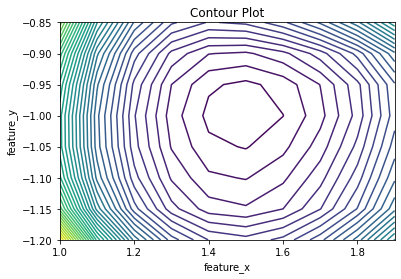

In [11]:

# Implementation of matplotlib function
import matplotlib.pyplot as plt
import numpy as np
  
feature_x = np.arange(1, 2, 0.1)
feature_y = np.arange(-1.2, -0.8, 0.05)
  
# Creating 2-D grid of features
[X, Y] = np.meshgrid(feature_x, feature_y)
  
fig, ax = plt.subplots(1, 1)
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i][j]=objective_func_no_err([X[i,j], Y[i,j]], list(target_values.values()), list(target_error.values()), list(coeff.values()))
  
# plots contour lines
ax.contour(X, Y, Z, 40)
  
ax.set_title('Contour Plot')
ax.set_xlabel('feature_x')
ax.set_ylabel('feature_y')
  
plt.show()

In [13]:
#Toy data
p_real = jnp.array([3.00, 4.80])
poly_real = timing_van_jax([p_real], 3)[0]
key = random.PRNGKey(20)
target_d_real = jnp.matmul(jnp.array(list(coeff.values())), poly_real.T) + 50*random.normal(key, shape=(40,))
targ_sig_real = 0.2*jnp.ones(40)


p_guess = jnp.array([0, 0])
p_opt = opt.minimize(objective_func, p_guess, args=(target_d_real, targ_sig_real, list(coeff.values()), list(cov.values())), method='Nelder-Mead')
print(p_opt)


#Math for covariance
def res_sq_sum(P):
    p_poly = timing_van_jax([P], 3)[0]
    return jnp.sum(jnp.square(jnp.matmul(jnp.array(list(coeff.values())), p_poly.T) - target_d_real))
def Hessian(func):
    return jacfwd(jacrev(res_sq_sum))
p_opt_cov = jnp.linalg.inv(Hessian(res_sq_sum)(p_opt.x))*res_sq_sum(p_opt.x)/(38)
p_opt_unc = jnp.sqrt(jnp.diagonal(p_opt_cov))


print("Returned parameters, we expect this to be the same as p_real ", p_opt.x)
print("Uncertainty in returned parameters, currently broken, expect this to be higher in correct versions ", p_opt_unc)
print("Target distribution ", target_d_real)

poly_opt = timing_van_jax([p_opt.x], 3)[0]
print("Distribution created from returned parameters ", jnp.matmul(jnp.array(list(coeff.values())), poly_opt.T).reshape(10, 4)) #Reshaped for comparison with target distribution



 final_simplex: (array([[-8.97557049,  7.56593779],
       [-8.97556832,  7.56593479],
       [-8.97551636,  7.56589131]]), array([208189.59375, 208189.59375, 208189.59375]))
           fun: 208189.59375
       message: 'Optimization terminated successfully.'
          nfev: 101
           nit: 40
        status: 0
       success: True
             x: array([-8.97557049,  7.56593779])
Returned parameters, we expect this to be the same as p_real  [-8.97557049  7.56593779]
Uncertainty in returned parameters, currently broken, expect this to be higher in correct versions  [2.0477118  0.26928395]
Target distribution  [-4.9927334e+03 -1.7462168e+04  6.3017705e+03  8.9518154e+03
 -2.1954502e+04 -3.3958577e+03 -3.2181104e+04  1.1705308e+03
 -2.3573932e+04  1.0340832e+04 -1.3200039e+04 -2.9126480e+02
 -5.4390015e+03  2.4279248e+03  1.0138946e+03  2.6494121e+03
  1.2114731e+03  1.4117120e+03  6.2990363e+02  1.0815963e+03
 -1.0997655e+04  7.9612441e+03 -4.1189566e+04 -5.3374230e+04
  8.5483953e+